<a href="https://colab.research.google.com/github/ranjith13119/Attention-MultiClassText-Classification/blob/main/BBC_MultiClass_Text_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8


First, let's define two lists that containing articles and labels. In the meantime, we remove stopwords

In [ ]:
articles = []
labels = []

with open("/content/drive/MyDrive/NLP/MultiClass Classification LSTM/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


There are only 2,225 articles in the data. Then we split into training set and validation set, according to the parameter we set earlier, 80% for training, 20% for validation.

In [ ]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


Tokenizer does all the heavy lifting for us. In our articles that it was tokenizing, it will take 5,000 most common words. oov_token is to put a special value in when an unseen word is encountered. This means I want "OOV" in bracket to be used to for words that are not in the word index. "fit_on_text" will go through all the text and create dictionary like this:

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [ ]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'also': 6,
 'mr': 3,
 'new': 8,
 'one': 10,
 'people': 7,
 'said': 2,
 'us': 9,
 'would': 4,
 'year': 5}

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


In [ ]:
print(set(labels))

{'politics', 'business', 'tech', 'sport', 'entertainment'}


In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [ ]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)



Before training deep neural network, we want to explore what our original article and article after padding look like. Running the following code, we explore the 11th article, we can see that some words become "OOV", because they did not make to the top 5,000.

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest intense trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film en

In [ ]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
num_epochs =  10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 4s - loss: 1.5953 - accuracy: 0.2798 - val_loss: 1.3103 - val_accuracy: 0.4180
Epoch 2/10
56/56 - 1s - loss: 1.2176 - accuracy: 0.5152 - val_loss: 1.0178 - val_accuracy: 0.7213
Epoch 3/10
56/56 - 1s - loss: 0.4407 - accuracy: 0.9056 - val_loss: 0.3253 - val_accuracy: 0.8899
Epoch 4/10
56/56 - 1s - loss: 0.1200 - accuracy: 0.9685 - val_loss: 0.2803 - val_accuracy: 0.9146
Epoch 5/10
56/56 - 1s - loss: 0.0369 - accuracy: 0.9899 - val_loss: 0.2148 - val_accuracy: 0.9483
Epoch 6/10
56/56 - 1s - loss: 0.0079 - accuracy: 0.9989 - val_loss: 0.2008 - val_accuracy: 0.9528
Epoch 7/10
56/56 - 1s - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.2500 - val_accuracy: 0.9416
Epoch 8/10
56/56 - 1s - loss: 0.0054 - accuracy: 0.9994 - val_loss: 0.1970 - val_accuracy: 0.9483
Epoch 9/10
56/56 - 1s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2315 - val_accuracy: 0.9461
Epoch 10/10
56/56 - 1s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2149 - val_accuracy: 0.9483


In [ ]:
import matplotlib.pyplot as plt

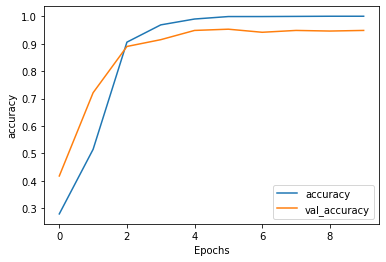

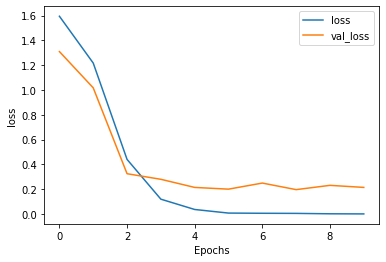

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
txt = ["kennedy questions trust of blair lib dem leader charles kennedy has said voters now have a  fundamental lack of trust  of tony blair as prime minister.  he said backing his party"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(pred, labels[np.argmax(pred)-1])

[[8.3245875e-05 5.4916349e-04 3.7144267e-04 4.4621222e-04 6.9108363e-03
  9.9163908e-01]] entertainment


In [ ]:
model.save("/content/drive/MyDrive/NLP/MultiClass Classification LSTM/bbc.h5")